## Imports

In [31]:
import sys
import time
import importlib
import sparse
import datetime
import pandas as pd
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt

import Utils.dbutils as dbutils
import Utils.data_utils as data_utils
# import Utils.PopulateAux as PopulateAux
import Generators.CohortGenerator as CohortGenerator
import Generators.FeatureGenerator as FeatureGenerator
import config
local_imports = (
    dbutils,
    data_utils,
    # PopulateAux,
    CohortGenerator,
    FeatureGenerator,
    config
)
for i in local_imports:
    i = importlib.reload(i)

## Cohort, Outcome and Feature Collection

### 1. Set up a connection to the OMOP CDM database

Parameters for connection to be specified in ./config.py

In [32]:
config_path = 'hive://localhost:10000/'
omop_cdm_schema = 'cdm'
db = dbutils.Database(config_path, omop_cdm_schema)

### Build a Cohort for the End of Life Prediction Task

##### Create a Cohort Object that can be constructed as specified by SQL File & Params

In [33]:
cohort_table_name = 'eol_cohort'
cohort_script_path = config.SQL_PATH_COHORTS + '/gen_EOL_cohort_medicare_no_enrollment_HIVE_SMALL.sql'

# cohort parameters  
params = {
          'omop_cdm_schema'       : omop_cdm_schema,
          'aux_data_schema'       : config.CDM_AUX_SCHEMA,
          'training_start_date'   : '2016-01-01',
          'training_end_date'     : '2017-01-01',
          'gap'                   : '3 months',
          'outcome_window'        : '6 months'
         }

### Get a Time Series of Features for Cohort Members

In [8]:
featureSet = FeatureGenerator.FeatureSet(db)
featureSet.add_default_features(
    ['drugs','conditions', 'procedures','specialty'],
    omop_cdm_schema=omop_cdm_schema,
    cohort_table_name=cohort_table_name
)

In [9]:
%%time
# Build the Feature Set by executing SQL queries and reading into sparse matrices
cache_data_path = '/tmp/cache_data_eol_test2'
cohort = featureSet.build(omop_cdm_schema=omop_cdm_schema,
                 cohort_table_name=cohort_table_name,
                 cohort_generation_script=cohort_script_path,
                 cohort_generation_kwargs=params,
                 outcome_col_name='y',
                 from_cached=False, 
                 cache_file=cache_data_path)

(4979103, 6)
Data loaded to buffer in 3346.03 seconds
Got Unique Concepts and Timestamps in 5.46 seconds
Created Index Mappings in 0.00 seconds
5082
Generated Sparse Representation of Data in 11.53 seconds
CPU times: user 1min 45s, sys: 3.66 s, total: 1min 49s
Wall time: 58min 59s


In [10]:
outcomes_filt, feature_matrix_3d_transpose, remap, good_feature_names = \
    FeatureGenerator.postprocess_feature_matrix(cohort, featureSet, cohort_generation_kwargs=params)

### Build a Model to Predict End of Life using this data

#### Transform Data to get a vector of counts over 1, 6, 12, 24 and infinity (represented by 10000 days) month windows for each Patient

In [11]:
%%time
feature_matrix_counts, feature_names = data_utils.window_data(
    window_lengths = [30, 180, 365, 730, 10000],
    feature_matrix = feature_matrix_3d_transpose,
    all_feature_names = good_feature_names,
    cohort_generation_kwargs = params,
    featureSet = featureSet
)

CPU times: user 26.3 s, sys: 168 ms, total: 26.5 s
Wall time: 26.5 s


In [12]:
feature_matrix_counts.T

<4968x88845 sparse matrix of type '<class 'numpy.float64'>'
	with 1206011 stored elements in Compressed Sparse Column format>

#### Set up a standard sklearn modelling pipeline

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

def sparse_ufunc(f):
    def wrapper(*a, **k):
        X = a[0]
        if not scipy.sparse.isspmatrix(X):
            raise ValueError
        X2 = X.copy()
        X2.data = f(X2.data, *(a[1:]), **k)
        return X2
    return wrapper

@sparse_ufunc
def tr_func(X, kwarg=1):
    return np.clip(X, 0, kwarg)

func = FunctionTransformer(
    func=tr_func,
    accept_sparse=True,
    validate=True,
    kw_args={'kwarg': 1}
)

#### Instantiate, Train, Validate and Test Model

In [14]:
from tqdm.notebook import tqdm

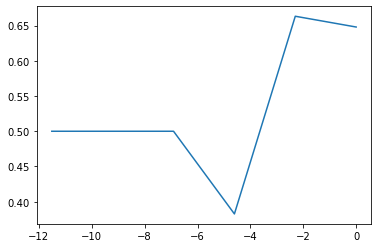

Model Test AUC: 0.67


In [15]:
indices = range(len(outcomes_filt))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    feature_matrix_counts.T, outcomes_filt, indices,
    test_size=0.33, random_state=1
)

# Define validation set and search space
VAL_SZ = 100
vals = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
scores = []
best_score = -1
best_model = None

# Pick best regularization constant
for C in tqdm(vals):
    lr = LogisticRegression(
        class_weight='balanced', C=C,
        penalty='l1', fit_intercept=True,
        solver='liblinear', random_state=0,
        verbose=0, max_iter = 200, tol=1e-1
    )
    clf = Pipeline([
        ('func',func),
        ('lr', lr)
    ])
    clf.fit(X_train, y_train)
    score = roc_auc_score(y_test[:VAL_SZ], clf.predict_proba(X_test[:VAL_SZ, :])[:, 1])
    if score > best_score:
        best_score = score
        best_model = clf
    scores.append(score)
    
# Show results
plt.plot(np.log(np.array(vals)), scores)
plt.show();
pred = best_model.predict_proba(X_test[VAL_SZ:, :])[:, 1]
print('Model Test AUC: {0:.2f}'.format(roc_auc_score(y_test[VAL_SZ:], pred)))

#### Evaluate Model : RoC and Precision-Recall Curves

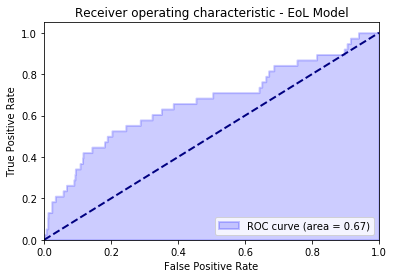

In [16]:
fpr, tpr, _ = roc_curve(y_test[VAL_SZ:], pred)
plt.figure()
lw = 2
plt.fill_between(fpr, tpr, color='b', alpha = 0.2,
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test[VAL_SZ:], pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - EoL Model')
plt.legend(loc="lower right")
plt.show()

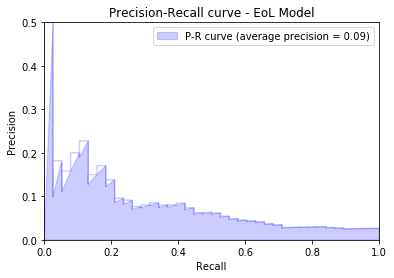

In [17]:
precision, recall, _ = precision_recall_curve(y_test[VAL_SZ:], pred)

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test[VAL_SZ:], pred)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(
    recall, precision, alpha=0.2, color='b',
    label='P-R curve (average precision = %0.2f)' % average_precision
)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 0.5])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right")
plt.title('Precision-Recall curve - EoL Model')
plt.show()

#### Evaluate Model : Extract Feature Weights

In [18]:
feature_weights = pd.DataFrame({
    'feature_name': feature_names,
    'feature_weight': list(best_model.get_params()['lr'].coef_[0])
}).sort_values(by='feature_weight')
pd.set_option('display.max_colwidth', -1)

/home/justinl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [19]:
feature_weights.tail(20)

,feature_name,feature_weight
71413,134438 - condition - Contact dermatitis - 10000 days,0.529160
86550,440417 - condition - Pulmonary embolism - 10000 days,0.531226
31527,42902111 - drug - methylprednisolone acetate 40 MG/ML Injectable Suspension [Depo-Medrol] - 180 days,0.554695
50464,436222 - condition - Altered mental status - 365 days,0.575325
72717,19079119 - drug - Nystatin 100000 UNT/ML Oral Suspension - 10000 days,0.586268
37196,19079658 - drug - Spironolactone 25 MG Oral Tablet - 365 days,0.591558
76341,"2211451 - procedure - Radiologic examination, elbow; complete, minimum of 3 views - 10000 days",0.596300
56627,"2102166 - procedure - Repair, intermediate, wounds of scalp, axillae, trunk and/or extremities (excluding hands and feet); 2.6 cm to 7.5 cm - 730 days",0.611915
87345,45768812 - condition - Anemia in chronic kidney disease - 10000 days,0.627178
59518,257011 - condition - Acute upper respiratory infection - 730 days,0.666515


In [20]:
feature_weights.head(20)

,feature_name,feature_weight
58765,"2211826 - procedure - Dual-energy X-ray absorptiometry (DXA), bone density study, 1 or more sites; axial skeleton (eg, hips, pelvis, spine) - 730 days",-1.118883
6051,"2414397 - procedure - Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: An expanded problem focused history; An expanded problem focused examination; Medical decision making of low - 30 days",-0.767099
80884,40164929 - drug - Metformin hydrochloride 500 MG Oral Tablet - 10000 days,-0.761438
70522,77670 - condition - Chest pain - 730 days,-0.755580
59359,"2414398 - procedure - Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: A detailed history; A detailed examination; Medical decision making of moderate complexity. Counseling and/o - 730 days",-0.718390
38227,200219 - condition - Abdominal pain - 365 days,-0.599438
72749,19080128 - drug - Lisinopril 10 MG Oral Tablet - 10000 days,-0.595966
76371,"2211488 - procedure - Radiologic examination, ankle; complete, minimum of 3 views - 10000 days",-0.595503
23819,"2414396 - procedure - Office or other outpatient visit for the evaluation and management of an established patient, which requires at least 2 of these 3 key components: A problem focused history; A problem focused examination; Straightforward medical decision making. Counselin - 180 days",-0.578739
67679,433736 - condition - Obesity - 730 days,-0.573255


In [21]:
for category in ['procedure', 'condition', 'drug', 'specialty']:
    print('Number of nonzero {} feature weights : {}'.format(
        category,
        sum(feature_weights.loc[
            [i for i,j in enumerate(feature_names) if '- ' + category + ' -' in j]
        ]['feature_weight'] != 0)
    ))

Number of nonzero procedure feature weights : 70
Number of nonzero condition feature weights : 120
Number of nonzero drug feature weights : 38
Number of nonzero specialty feature weights : 1
